# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Compute the $Q_0$

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
from mltier1 import Field, Q_0, parallel_process, describe

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
from IPython.display import clear_output

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Area limits

In [7]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [8]:
field = Field(170.0, 190.0, 46.8, 55.9)

## Load data

In [9]:
combined = Table.read("pw.fits")

In [10]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_merge_ID_optical_v0.7.fits")

In [11]:
np.array(combined.colnames)

array(['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 'W1mag',
       'W1magErr', 'i', 'iErr'],
      dtype='<U8')

In [12]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux',
       'E_Peak_flux', 'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min',
       'E_Min', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA',
       'DC_PA', 'E_DC_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID', 'ID_flag',
       'ID_name', 'ID_ra', 'ID_dec', 'ML_LR', 'LGZ_Size', 'LGZ_Width',
       'LGZ_PA', 'LGZ_Assoc', 'LGZ_Assoc_Qual', 'LGZ_ID_Qual', 'AllWISE',
       'objID', 'gFApFlux', 'gFApFluxErr', 'gFApMag', 'gFApMagErr',
       'rFApFlux', 'rFApFluxErr', 'rFApMag', 'rFApMagErr', 'iFApFlux',
       'iFApFluxErr', 'iFApMag', 'iFApMagErr', 'zFApFlux', 'zFApFluxErr',
       'zFApMag', 'zFApMagErr', 'yFApFlux', 'yFApFluxErr', 'yFApMag',
       'yFApMagErr', 'w1Flux', 'w1FluxErr', 'w1Mag', 'w1MagErr', 'w2Flux',
       'w2FluxErr', 'w2Mag', 'w2MagErr', 'w3Flux', 'w3FluxErr', 'w3Mag',
       'w3MagErr', 'w4Flux', 'w4FluxErr', 'w4Mag', 'w4MagErr', 'XrayClass',
       '2RXS_ID', 'XMMSL2_ID', 'IRClass', 'z_spec', 'z_source'

### Filter catalogues

In [13]:
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]

In [14]:
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.) &
                                         (lofar_aux['ID_flag'] == 1)], 
                               colnames=("RA", "DEC"))

### Sky coordinates

In [15]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [16]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Summary of galaxy types in the combined catalogue

In [17]:
combined_matched = (~np.isnan(combined["i"]) & 
                    ~np.isnan(combined["W1mag"]))
np.sum(combined_matched) # Matches

8196213

In [18]:
combined_panstarrs = (~np.isnan(combined["i"]) & 
                      np.isnan(combined["W1mag"]))
np.sum(combined_panstarrs) # Only PanSTARSS

13454849

In [19]:
combined_wise =(np.isnan(combined["i"]) & 
                ~np.isnan(combined["W1mag"]))
np.sum(combined_wise) # Only WISE

5023475

In [20]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise

## $Q_0$ dependence on the radius

We will iterate 10 times for each radius. However, the error is so small that a direct computation can be accurate to 4 significant figures.

In [21]:
n_iter = 10

In [22]:
rads = list(range(1,26))

### i-band

In [23]:
q_0_comp_i = Q_0(coords_lofar, coords_combined[combined_i], field)

In [24]:
q_0_rad_i = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_i(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_i.append(np.mean(q_0_rad_aux))
    print("{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(radius, 
            np.mean(q_0_rad_aux), np.std(q_0_rad_aux), 
            np.min(q_0_rad_aux), np.max(q_0_rad_aux)))

 1 0.39413 +/- 0.00016 [0.39380 0.39434]
 2 0.48357 +/- 0.00020 [0.48327 0.48385]
 3 0.50329 +/- 0.00044 [0.50227 0.50382]
 4 0.51252 +/- 0.00050 [0.51176 0.51341]
 5 0.51780 +/- 0.00081 [0.51648 0.51903]
 6 0.52056 +/- 0.00089 [0.51935 0.52259]
 7 0.52273 +/- 0.00090 [0.52129 0.52388]
 8 0.52444 +/- 0.00093 [0.52318 0.52635]
 9 0.52960 +/- 0.00081 [0.52792 0.53080]
10 0.53035 +/- 0.00070 [0.52888 0.53134]
11 0.53263 +/- 0.00184 [0.53054 0.53554]
12 0.53479 +/- 0.00131 [0.53246 0.53751]
13 0.53533 +/- 0.00244 [0.53189 0.54002]
14 0.53758 +/- 0.00196 [0.53329 0.54038]
15 0.54007 +/- 0.00235 [0.53621 0.54489]
16 0.54070 +/- 0.00305 [0.53498 0.54514]
17 0.54429 +/- 0.00355 [0.53818 0.54888]
18 0.55033 +/- 0.00249 [0.54644 0.55433]
19 0.54823 +/- 0.00287 [0.54543 0.55494]
20 0.54586 +/- 0.00475 [0.53766 0.55228]
21 0.55429 +/- 0.00756 [0.54048 0.56561]
22 0.55550 +/- 0.00304 [0.55108 0.55963]
23 0.55332 +/- 0.00470 [0.54847 0.56194]
24 0.56708 +/- 0.00481 [0.55819 0.57476]
25 0.56249 +/- 0

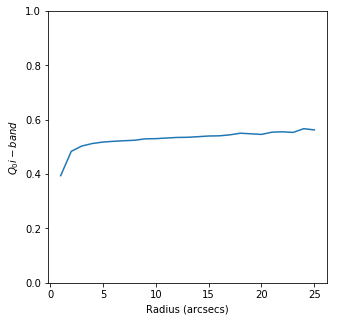

In [26]:
plt.rcParams["figure.figsize"] = (5,5)
plot(rads, q_0_rad_i)
xlabel("Radius (arcsecs)")
ylabel("$Q_0 i-band$")
ylim([0, 1]);

### W1-band

In [27]:
q_0_comp_w1 = Q_0(coords_lofar, coords_combined[combined_w1], field)

In [28]:
q_0_rad_w1 = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    print("{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(radius, 
            np.mean(q_0_rad_aux), np.std(q_0_rad_aux), 
            np.min(q_0_rad_aux), np.max(q_0_rad_aux)))

 1 0.48524 +/- 0.00010 [0.48502 0.48542]
 2 0.63343 +/- 0.00010 [0.63328 0.63356]
 3 0.67743 +/- 0.00022 [0.67700 0.67766]
 4 0.69943 +/- 0.00028 [0.69880 0.69979]
 5 0.71294 +/- 0.00026 [0.71235 0.71331]
 6 0.72313 +/- 0.00024 [0.72286 0.72370]
 7 0.73413 +/- 0.00040 [0.73348 0.73475]
 8 0.74562 +/- 0.00036 [0.74494 0.74606]
 9 0.75778 +/- 0.00047 [0.75675 0.75844]
10 0.76674 +/- 0.00048 [0.76615 0.76777]
11 0.77369 +/- 0.00064 [0.77260 0.77463]
12 0.77679 +/- 0.00066 [0.77542 0.77805]
13 0.77938 +/- 0.00079 [0.77819 0.78081]
14 0.78367 +/- 0.00049 [0.78304 0.78470]
15 0.78435 +/- 0.00051 [0.78328 0.78523]
16 0.78549 +/- 0.00120 [0.78405 0.78757]
17 0.78550 +/- 0.00073 [0.78398 0.78636]
18 0.78448 +/- 0.00110 [0.78259 0.78630]
19 0.78348 +/- 0.00103 [0.78117 0.78471]
20 0.78288 +/- 0.00127 [0.78124 0.78478]
21 0.78059 +/- 0.00112 [0.77867 0.78260]
22 0.77920 +/- 0.00159 [0.77625 0.78235]
23 0.77334 +/- 0.00210 [0.77012 0.77718]
24 0.77049 +/- 0.00216 [0.76685 0.77462]
25 0.76658 +/- 0

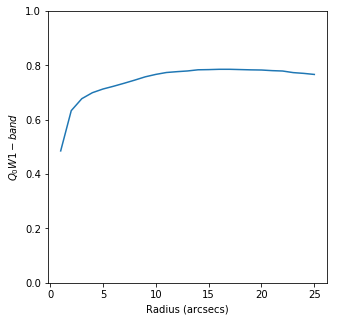

In [29]:
plt.rcParams["figure.figsize"] = (5,5)
plot(rads, q_0_rad_w1)
xlabel("Radius (arcsecs)")
ylabel("$Q_0 W1-band$")
ylim([0, 1]);